# Lowa 리뷰 분석

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re

from datetime import datetime
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# 지수 표기법을 10진수로 변경
pd.set_option('display.float_format', '{:.2f}'.format)

import platform

system = platform.system()

if system == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
else:
    !apt-get -y install fonts-nanum
    !fc-cache -fv
    !rm ~/.cache/matplotlib -rf

    plt.rcParams['font.family'] = 'NanumBarunGothic'

## 데이터 전처리

In [2]:
df = pd.read_csv("./data/lowa_db_reviews_new.csv")
df

,_id,product_name,product_price,writer,content,size,date,rate
0,678dfdf1060da44f87c631c5,로바 액티브 크림 75ml (가죽 컨디셔너),11700,jhor***,등산화에 잘 발라주니 너무 좋네요,NaN,25.01.18.,4
1,678dfdf1060da44f87c631c6,로바 액티브 크림 75ml (가죽 컨디셔너),11700,zeuf***,아직 안써봤지만 잘 쓸게요.,NaN,25.01.08.,5
2,678dfdf1060da44f87c631c7,로바 액티브 크림 75ml (가죽 컨디셔너),11700,ekgo***,한달사용아직 사용전이지만 성능 좋을거\n같아요,NaN,24.12.10.,5
3,678dfdf1060da44f87c631c8,로바 액티브 크림 75ml (가죽 컨디셔너),11700,blue*******,새등산화 신고 본의아니게 폭우트레킹을 해서 세척을 했더니...색 바랜 헌신이 되어 ...,NaN,24.11.01.,5
4,678dfdf1060da44f87c631c9,로바 액티브 크림 75ml (가죽 컨디셔너),11700,ekgo***,착화감 튼튼함 디자인 좋아요,NaN,24.11.06.,5
...,...,...,...,...,...,...,...,...
937,678e033a060da44f87c6356e,로바 매독스 LOW GTX 스틸블루 여성 트레킹화,227200,hayo*****,튼튼하게 잘 나온것 같아요\n좋은가격에 구입해서\n잘 신겠습니다,320609 7922: 사이즈 UK5.5\n평소사이즈240mm발볼 보통발등 보통착용...,23.08.14.,5
938,678e033a060da44f87c6356f,로바 매독스 LOW GTX 스틸블루 여성 트레킹화,227200,dain***,한달사용very easy to get on and comfortable!!,320609 7922: 사이즈 UK4.5\n평소사이즈235mm발볼 보통발등 보통착용...,23.08.19.,5
939,678e033a060da44f87c63570,로바 매독스 LOW GTX 스틸블루 여성 트레킹화,227200,dain***,light and very good fitting.,320609 7922: 사이즈 UK4.5\n평소사이즈260mm발볼 보통발등 보통사이...,23.07.12.,5
940,678e033a060da44f87c63571,로바 매독스 LOW GTX 스틸블루 여성 트레킹화,227200,sad1*****,한달사용얼마 신지도 않았는데 신발 끈이 끊어 졌어요,320609 7922: 사이즈 UK6\n착용감편해요발볼폭이 적당해요사이즈잘 맞아요,23.05.31.,2


In [3]:
df['content'] = df.apply(lambda x: x['content'].replace(str(x['size']), '') if pd.notna(x['size']) else x['content'], axis=1).str.replace('\\n',' ')
df['size'] = df['size'].str.replace('\\n', ' ')

In [4]:
# 날짜 형식 변환
# 먼저 마지막 점(.)을 제거하고 '20'을 앞에 추가하여 완전한 연도로 만듦
df['date'] = '20' + df['date'].str.replace('.', '')
# datetime으로 변환
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
# YY-MM 형식으로 Month 컬럼 생성
df['Month'] = df['date'].dt.strftime('%y-%m')

In [5]:
product_list = df['product_name'].unique()

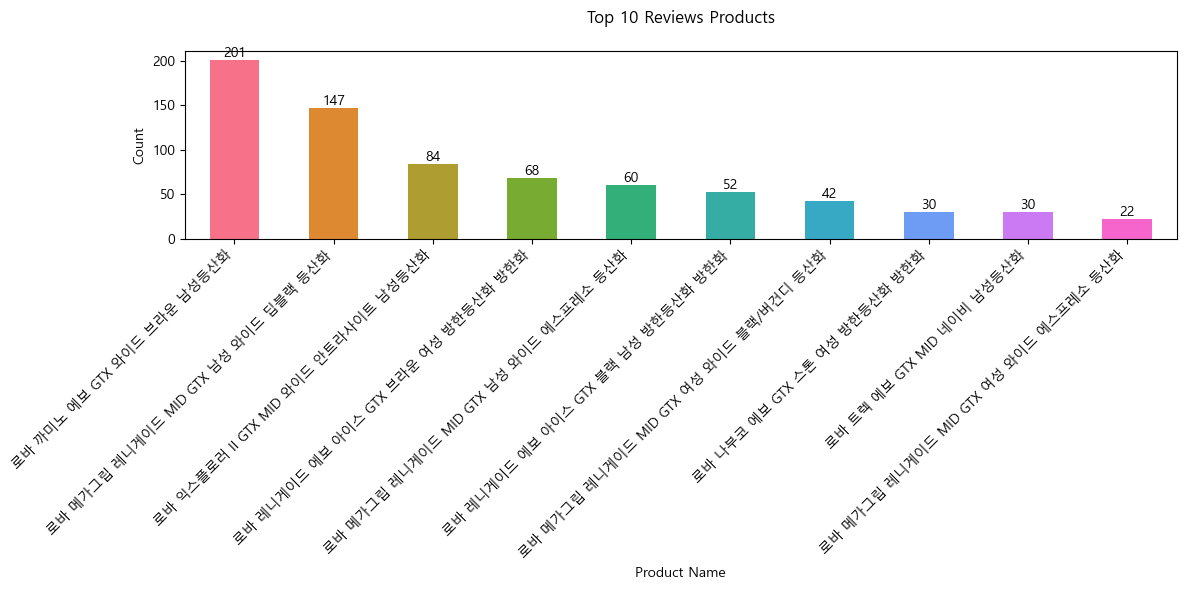

In [6]:
# top 10 추출 및 시각화
top_10 = df['product_name'].value_counts().head(10)

plt.figure(figsize=(12, 6))

# 색상 팔레트 적용 (seaborn의 pastel 팔레트 사용)
colors = sns.color_palette('husl', n_colors=10)
ax = top_10.plot(kind='bar', color=colors)

# 막대 위에 숫자 표시
for i, v in enumerate(top_10):
   ax.text(i, v, str(v), ha='center', va='bottom')

plt.title('Top 10 Reviews Products', pad=20)
plt.xlabel('Product Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 상위 2개의 제품에 대한 리뷰만 분석

In [7]:
top2_list = df['product_name'].value_counts().head(2)

In [17]:
# top2 제품의 이름과 가격 추출
for product_name in top2_list.index:
    # 해당 제품의 첫 번째 가격 정보 추출 (같은 제품은 같은 가격이므로)
    price = df[df['product_name'] == product_name]['product_price'].iloc[0]
    print(f"제품명: {product_name}")
    print(f"가격: {price}원\n")

제품명: 로바 까미노 에보 GTX 와이드 브라운 남성등산화
가격: 384000원

제품명: 로바 메가그립 레니게이드 MID GTX 남성 와이드 딥블랙 등산화
가격: 296000원



In [8]:
top2_list

product_name
로바 까미노 에보 GTX 와이드 브라운 남성등산화             201
로바 메가그립 레니게이드 MID GTX 남성 와이드 딥블랙 등산화    147
Name: count, dtype: int64

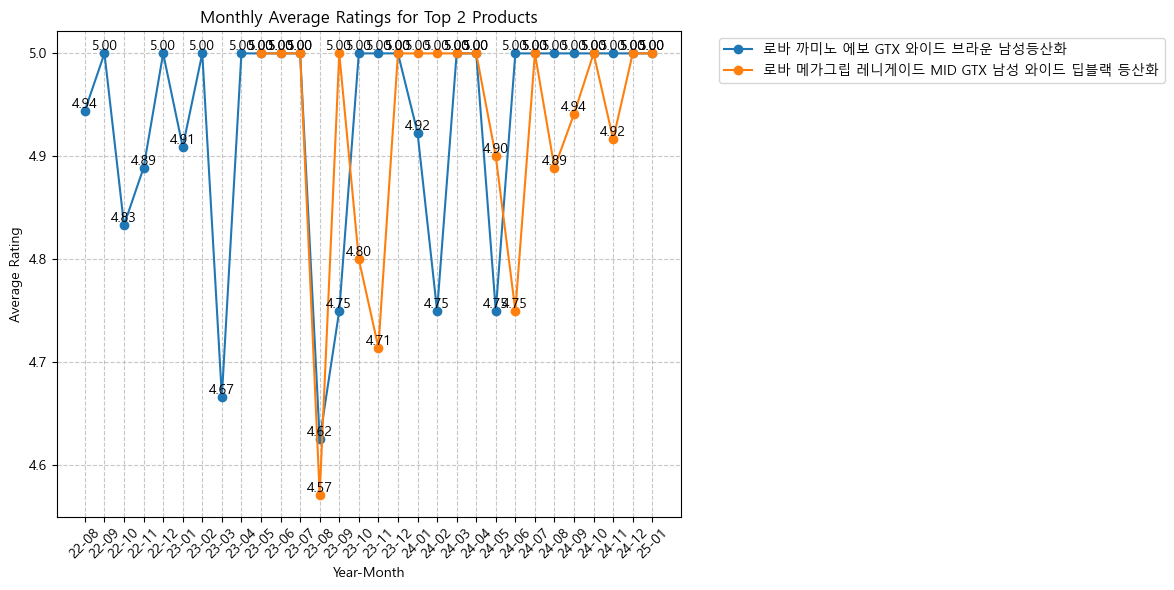

In [9]:
# top 2 제품들의 데이터만 필터링
top2_df = df[df['product_name'].isin(top2_list.index)]

# 월별 평균 평점 계산
monthly_ratings = top2_df.groupby(['Month', 'product_name'])['rate'].mean().unstack()

# 시각화
plt.figure(figsize=(12, 6))

# 선 그래프 그리기
for product in monthly_ratings.columns:
    plt.plot(monthly_ratings.index, monthly_ratings[product], marker='o', label=product)

plt.title('Monthly Average Ratings for Top 2 Products')
plt.xlabel('Year-Month')
plt.ylabel('Average Rating')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

# 각 점에 값 표시
for product in monthly_ratings.columns:
    for i, v in enumerate(monthly_ratings[product]):
        if not pd.isna(v):  # NaN이 아닌 경우에만 표시
            plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

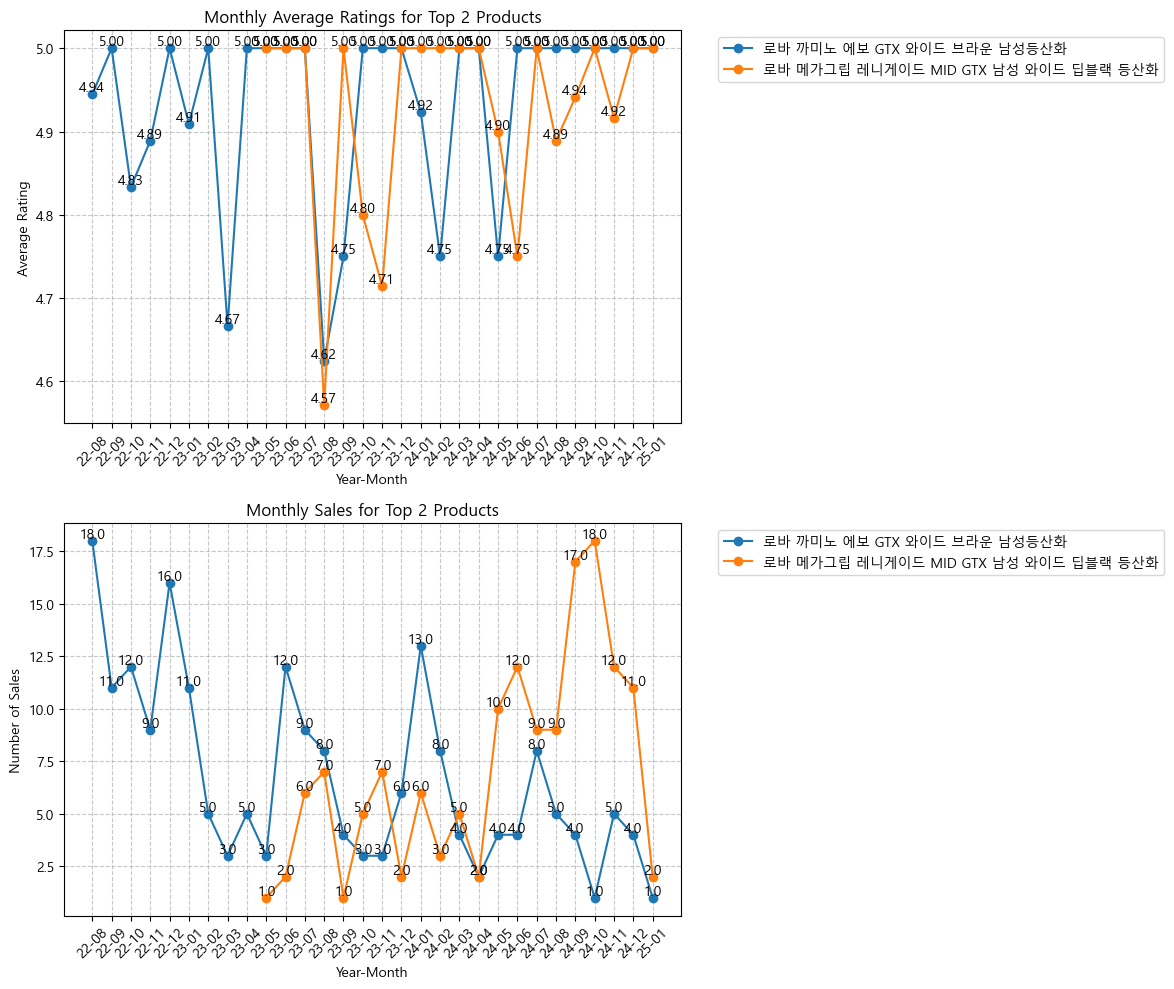

In [10]:
# 두 개의 서브플롯 생성
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# 월별 평균 평점 계산 및 시각화
monthly_ratings = top2_df.groupby(['Month', 'product_name'])['rate'].mean().unstack()

for product in monthly_ratings.columns:
    ax1.plot(monthly_ratings.index, monthly_ratings[product], marker='o', label=product)
    # 값 표시
    for i, v in enumerate(monthly_ratings[product]):
        if not pd.isna(v):
            ax1.text(i, v, f'{v:.2f}', ha='center', va='bottom')

ax1.set_title('Monthly Average Ratings for Top 2 Products')
ax1.set_xlabel('Year-Month')
ax1.set_ylabel('Average Rating')
ax1.legend(bbox_to_anchor=(1.05, 1))
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.tick_params(axis='x', rotation=45)

# 월별 판매량 계산 및 시각화
monthly_sales = top2_df.groupby(['Month', 'product_name']).size().unstack()

for product in monthly_sales.columns:
    ax2.plot(monthly_sales.index, monthly_sales[product], marker='o', label=product)
    # 값 표시
    for i, v in enumerate(monthly_sales[product]):
        if not pd.isna(v):
            ax2.text(i, v, str(v), ha='center', va='bottom')

ax2.set_title('Monthly Sales for Top 2 Products')
ax2.set_xlabel('Year-Month')
ax2.set_ylabel('Number of Sales')
ax2.legend(bbox_to_anchor=(1.05, 1))
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

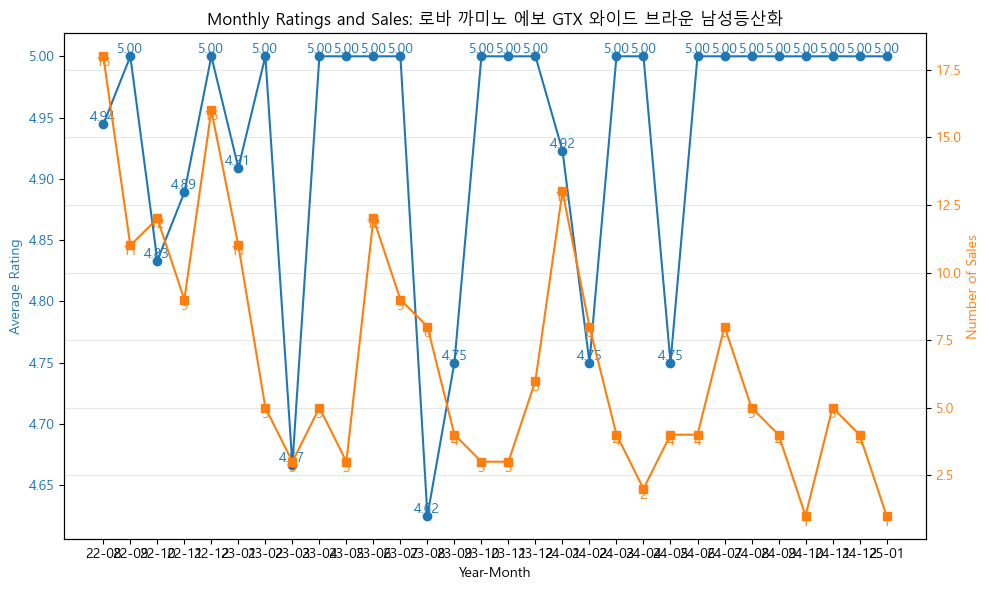

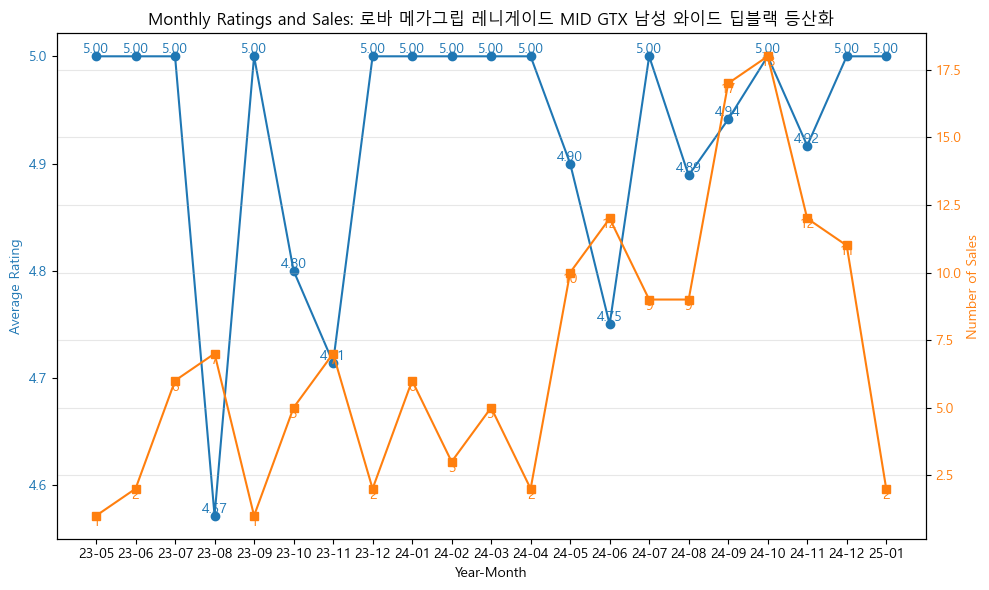

In [11]:
# top 2 제품 각각에 대해 그래프 생성
for product in top2_list.index:
    # 해당 제품 데이터만 필터링
    product_df = df[df['product_name'] == product]
    
    # 월별 평균 평점과 판매량 계산
    monthly_data = product_df.groupby('Month').agg({
        'rate': 'mean',
        'product_name': 'count'
    }).rename(columns={'product_name': 'sales'})
    
    # 그래프 생성
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # 평균 평점 그래프 (왼쪽 y축)
    color1 = '#1f77b4'  # 파란색
    ax1.set_xlabel('Year-Month')
    ax1.set_ylabel('Average Rating', color=color1)
    line1 = ax1.plot(monthly_data.index, monthly_data['rate'], color=color1, marker='o')
    ax1.tick_params(axis='y', labelcolor=color1)
    
    # 판매량 그래프 (오른쪽 y축)
    ax2 = ax1.twinx()
    color2 = '#ff7f0e'  # 주황색
    ax2.set_ylabel('Number of Sales', color=color2)
    line2 = ax2.plot(monthly_data.index, monthly_data['sales'], color=color2, marker='s')
    ax2.tick_params(axis='y', labelcolor=color2)
    
    # 값 표시
    for i, v in enumerate(monthly_data['rate']):
        ax1.text(i, v, f'{v:.2f}', color=color1, ha='center', va='bottom')
    for i, v in enumerate(monthly_data['sales']):
        ax2.text(i, v, str(v), color=color2, ha='center', va='top')
    
    plt.title(f'Monthly Ratings and Sales: {product}')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

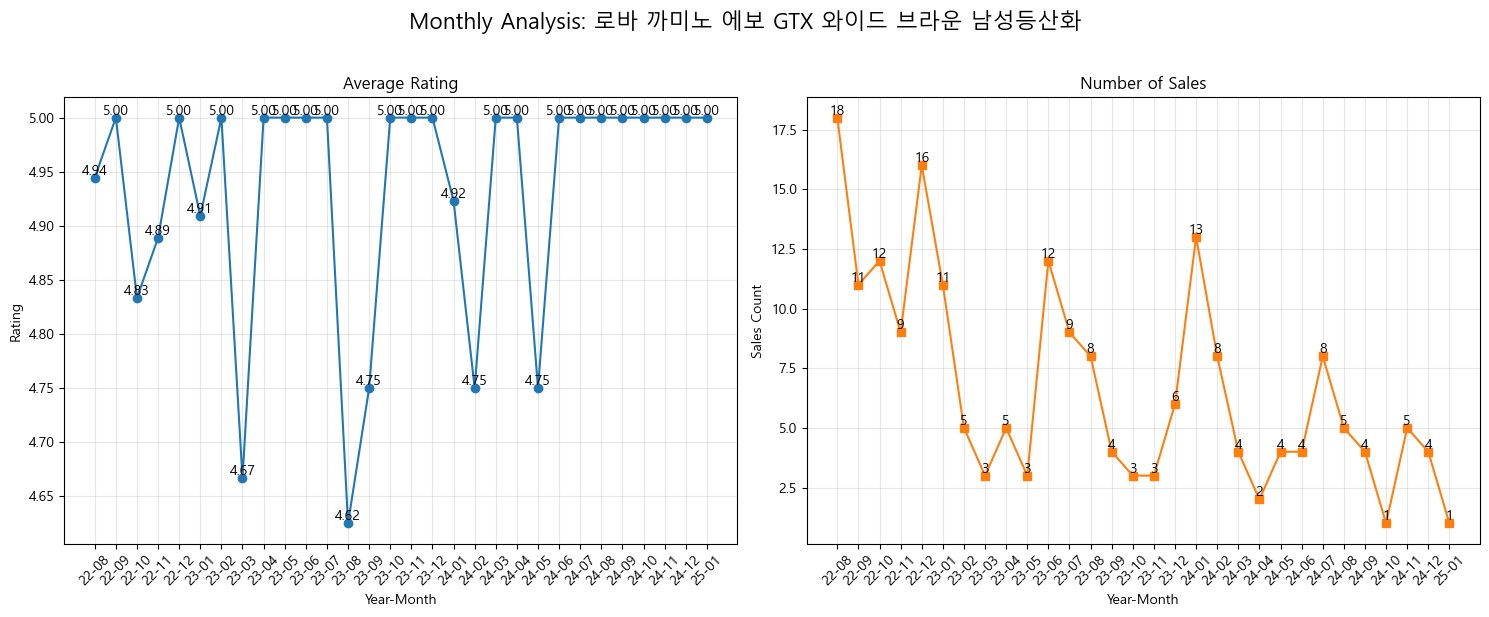

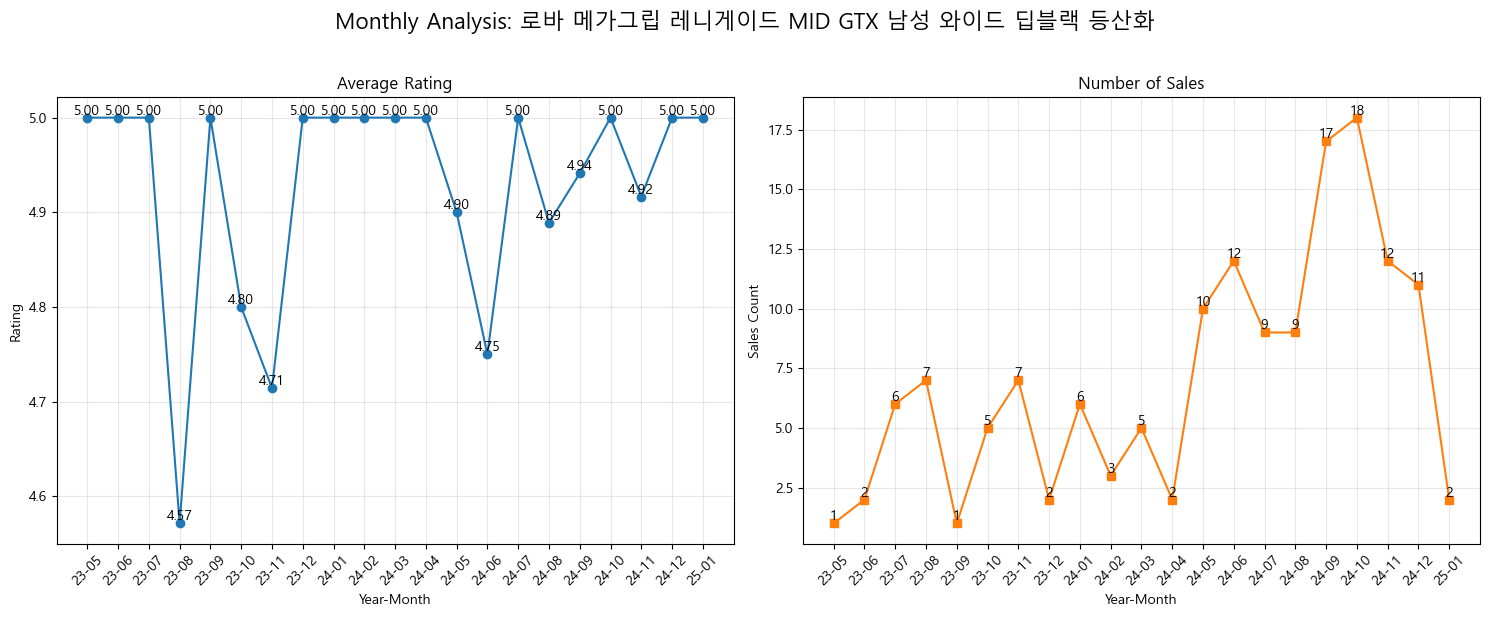

In [12]:
for product in top2_list.index:
    # 해당 제품 데이터만 필터링
    product_df = df[df['product_name'] == product]
    
    # 월별 데이터 계산
    monthly_data = product_df.groupby('Month').agg({
        'rate': 'mean',
        'product_name': 'count'
    }).rename(columns={
        'product_name': 'sales'
    })
    
    # 1x2 서브플롯 생성
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(f'Monthly Analysis: {product}', fontsize=16, y=1.02)
    
    # 1. 평균 평점 그래프
    ax1.plot(monthly_data.index, monthly_data['rate'], color='#1f77b4', marker='o')
    ax1.set_title('Average Rating')
    ax1.set_xlabel('Year-Month')
    ax1.set_ylabel('Rating')
    ax1.grid(True, alpha=0.3)
    for i, v in enumerate(monthly_data['rate']):
        ax1.text(i, v, f'{v:.2f}', ha='center', va='bottom')
    ax1.tick_params(axis='x', rotation=45)
    
    # 2. 판매량 그래프
    ax2.plot(monthly_data.index, monthly_data['sales'], color='#ff7f0e', marker='s')
    ax2.set_title('Number of Sales')
    ax2.set_xlabel('Year-Month')
    ax2.set_ylabel('Sales Count')
    ax2.grid(True, alpha=0.3)
    for i, v in enumerate(monthly_data['sales']):
        ax2.text(i, v, str(v), ha='center', va='bottom')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()


=== 로바 까미노 에보 GTX 와이드 브라운 남성등산화 분석 결과 ===


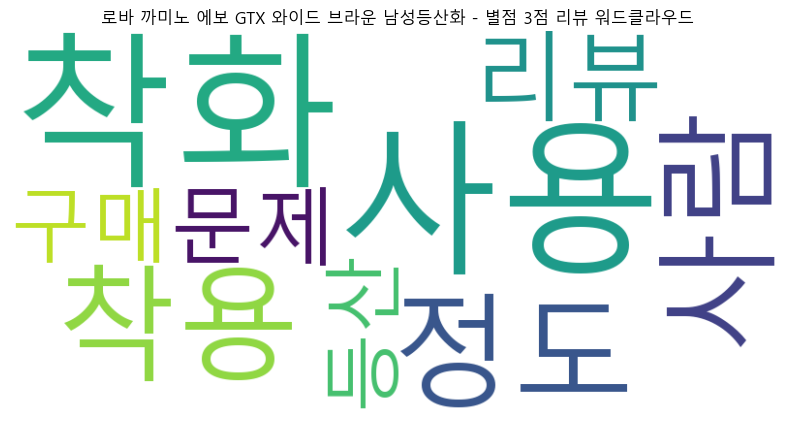


로바 까미노 에보 GTX 와이드 브라운 남성등산화 - 별점 3점의 상위 10개 단어:
사용: 2회
착화: 2회
정도: 1회
착용: 1회
사람: 1회
리뷰: 1회
문제: 1회
구매: 1회
등산: 1회


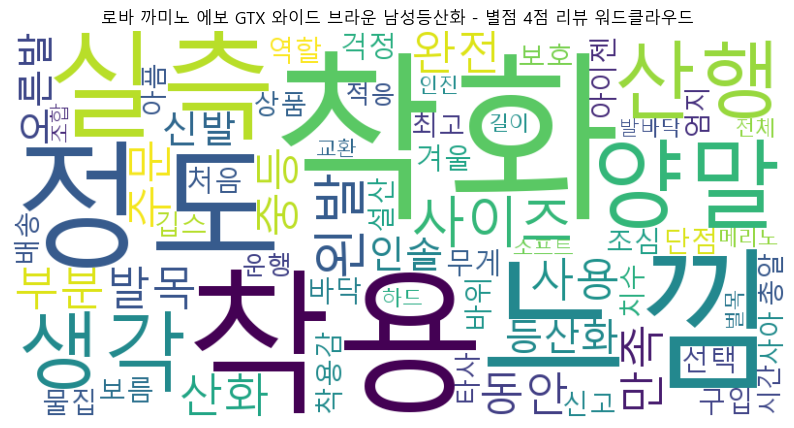


로바 까미노 에보 GTX 와이드 브라운 남성등산화 - 별점 4점의 상위 10개 단어:
착화: 7회
착용: 5회
느낌: 5회
정도: 4회
실측: 4회
양말: 4회
생각: 3회
산행: 3회
사이즈: 3회
왼발: 3회


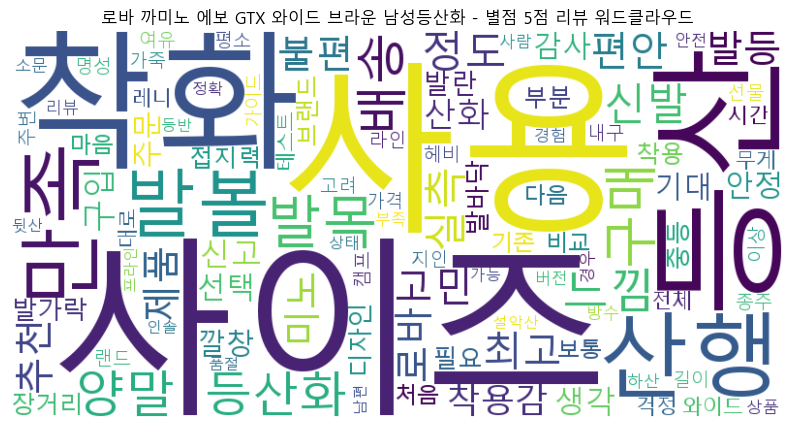


로바 까미노 에보 GTX 와이드 브라운 남성등산화 - 별점 5점의 상위 10개 단어:
사이즈: 54회
사용: 50회
착화: 46회
등산: 41회
산행: 35회
만족: 28회
발볼: 28회
발목: 27회
구매: 24회
배송: 22회

=== 로바 메가그립 레니게이드 MID GTX 남성 와이드 딥블랙 등산화 분석 결과 ===


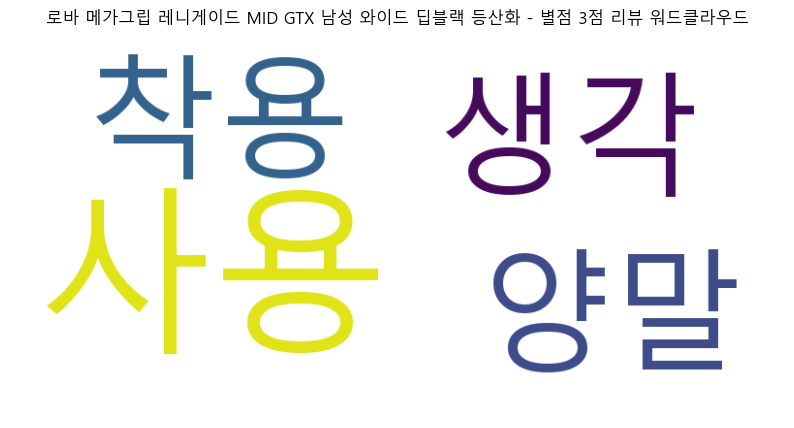


로바 메가그립 레니게이드 MID GTX 남성 와이드 딥블랙 등산화 - 별점 3점의 상위 10개 단어:
사용: 2회
생각: 1회
양말: 1회
착용: 1회


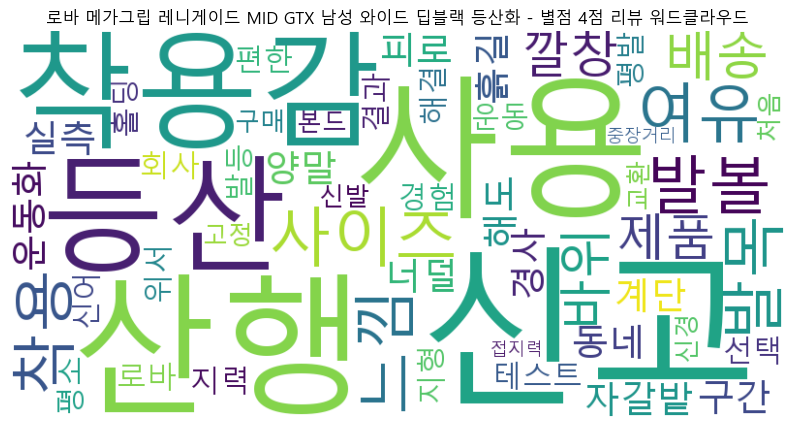


로바 메가그립 레니게이드 MID GTX 남성 와이드 딥블랙 등산화 - 별점 4점의 상위 10개 단어:
신고: 4회
사용: 3회
산행: 3회
착용감: 3회
등산: 3회
사이즈: 2회
발볼: 2회
여유: 2회
느낌: 2회
착용: 2회


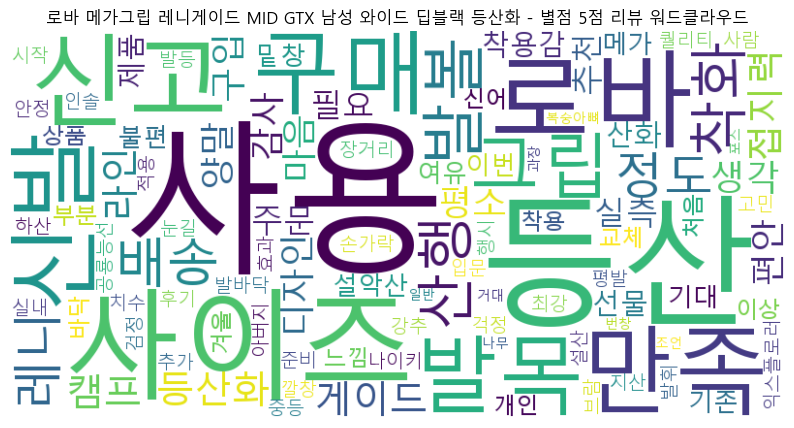


로바 메가그립 레니게이드 MID GTX 남성 와이드 딥블랙 등산화 - 별점 5점의 상위 10개 단어:
사용: 49회
등산: 35회
사이즈: 24회
로바: 18회
신고: 17회
만족: 15회
신발: 14회
구매: 13회
발목: 12회
그립: 12회


In [15]:
from eunjeon import Mecab
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# MeCab 형태소 분석기 초기화
mecab = Mecab()

# 불용어 정의
stopwords = {'너무', '정말', '진짜', '아주', '매우', '좋다', '좋은', '좋아요', '좋고', 
             '같다', '같은', '같아요', '이다', '이고', '입니다', '있다', '하다', '하고',
             '그리고', '입니다', '있어요', '없다', '없어요', '했다', '했어요', '네요',
             '음', '는', '을', '를', '이', '가', '의', '과', '로', '으로'}

def get_nouns(text):
    morphs = mecab.pos(str(text))
    nouns = []
    for word, tag in morphs:
        if tag.startswith('NN'):  
            if len(word) > 1 and word not in stopwords:
                nouns.append(word)
    return nouns

# 상위 2개 제품 선택
top2_list = df['product_name'].value_counts().head(2)

# 각 제품별로 워드클라우드 생성
for product_name in top2_list.index:
    print(f"\n=== {product_name} 분석 결과 ===")
    
    # 해당 제품의 데이터만 필터링
    product_df = df[df['product_name'] == product_name]
    
    # 별점별 워드클라우드 생성 (1-5점)
    for rate in range(1, 6):
        # 해당 별점의 리뷰만 필터링
        rate_df = product_df[product_df['rate'] == rate]
        
        # 모든 리뷰에서 명사 추출
        all_nouns = []
        for text in rate_df['content']:
            all_nouns.extend(get_nouns(text))
        
        # 단어 빈도수 계산
        word_count = Counter(all_nouns)
        
        # 워드클라우드 생성
        wc = WordCloud(
            font_path='C:/Windows/Fonts/malgun.ttf',
            width=800,
            height=400,
            background_color='white',
            max_words=100,
            colormap='viridis'
        )
        
        if word_count:  # 해당 별점의 리뷰가 있는 경우에만
            wc.generate_from_frequencies(word_count)
            
            # 워드클라우드 시각화
            plt.figure(figsize=(10, 8))
            plt.imshow(wc, interpolation='bilinear')
            plt.axis('off')
            plt.title(f'{product_name} - 별점 {rate}점 리뷰 워드클라우드')
            plt.show()
            
            # 상위 10개 단어와 빈도수 출력
            print(f'\n{product_name} - 별점 {rate}점의 상위 10개 단어:')
            for word, count in word_count.most_common(10):
                print(f'{word}: {count}회')